In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scsp
import scipy.integrate as scint
import sys
import scipy.stats
sys.path.insert(0, '/users/milan/nudetect')
import nudetect

In [2]:
CIT2037 = nudetect.Source("Eu155", 2037)

In [3]:
h119_Eu155 = nudetect.GammaFlood("floodEu155_5C_-500V_20190816_small_region_capoffset_corrected.fits",
                                 detector="H119",
                                 source = CIT2037,
                                 voltage = 500,
                                 temp=5,
                                 data_dir='Eu155_capoffset/data',
                                 plot_dir='Eu155_capoffset/plots'
                                )

In [4]:
h119_Eu155.load_raw_data()

In [5]:
h119_Eu155.gen_count_map()

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint32)

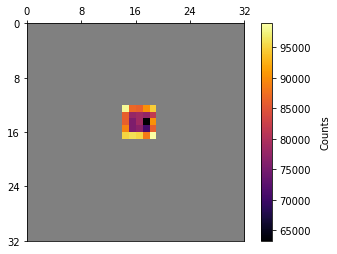

In [6]:
h119_Eu155.plot_pixel_map('Count')
#h119_Am241.plot_pixel_hist('Count')

In [7]:
other_data, _ = nudetect.fits_to_df("floodEu155_5C_-500V_20190816_small_region.fits",
                                   ["GRADE"],
                                   pos=0)
tp_mask = (h119_Eu155.raw_data_1d['STIM'] == 1)
grade_mask = (other_data['GRADE'] == 0)
bad_pix_mask = (h119_Eu155.raw_data_1d['RAWX'] == 17) & (h119_Eu155.raw_data_1d['RAWY'] == 14)

In [10]:
%%time
h119_Eu155.gen_quick_gain(plot_subdir='gamma_pix', misc_mask=~(tp_mask | bad_pix_mask) & grade_mask)

/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4

CPU times: user 31min 41s, sys: 2min 9s, total: 33min 51s
Wall time: 3min 16s


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0)

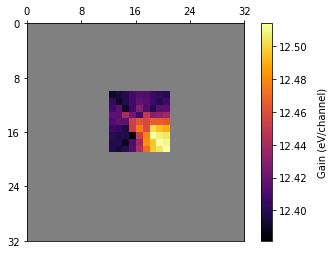

In [11]:
h119_Eu155.plot_pixel_map('Gain')

In [12]:
%%time
h119_Eu155.gen_spectrum(misc_mask=~(tp_mask | bad_pix_mask) & grade_mask)

CPU times: user 31min 1s, sys: 2min 5s, total: 33min 6s
Wall time: 3min 53s


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.00000000e+00, 1.00000000e+00, 2.00000000e+00],
       [1.59995000e-02, 2.79985000e-02, 3.99975000e-02, ...,
        1.19970002e+02, 1.19982001e+02, 1.19994000e+02]])

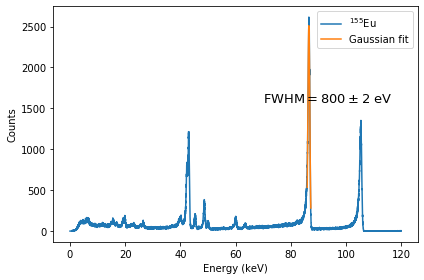

In [13]:
h119_Eu155.plot_spectrum(fit_below=50, fit_above=60)

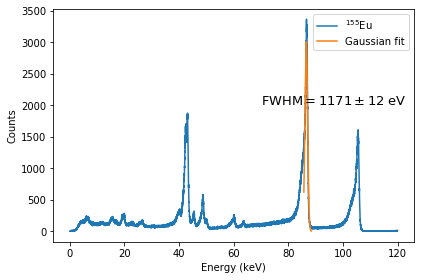

In [25]:
# no mask
h119_Eu155.gen_quick_gain(save_plot=False, save_data=False)
h119_Eu155.gen_spectrum(save_data=False)
h119_Eu155.plot_spectrum(save_plot=False)

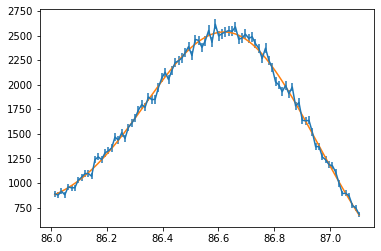

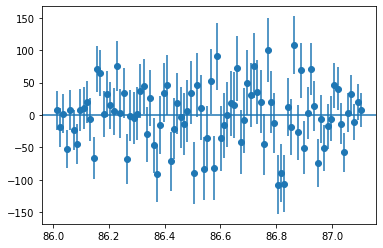

1.2349884224624124


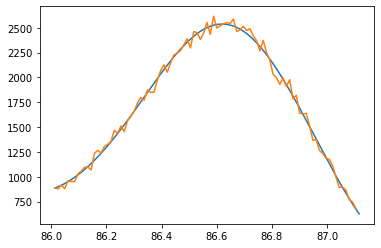

0.7908679687697457


In [43]:
fwhm_86, line_86 = fit_line(clean_grade0_spectrum, upper=7259, lower=7167,
                                  plot=True, intercept=50, slope=-10)

In [66]:
def tie_stddevs(model):
    return model.stddev_0

def tie_stddevs3(model):
    return model.stddev_3

def tie_means(model):
    return model.mean_0

def tie_means3(model):
    return model.mean_3

def exp_tail(x, norm=1, mean=0, stddev=1, slope=1):
    return norm*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev))

def exp_tail_deriv(x, norm=1, mean=0, stddev=1, slope=1):
    return [
        np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*np.exp(slope*(x-mean) - (x - mean)**2 / stddev**2 * 0.5)/(stddev*np.sqrt(2*np.pi)) -\
            norm*slope*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*(x-mean)*np.exp(slope*(x-mean) - (x - mean)**2 / stddev**2 * 0.5)/(stddev*stddev*np.sqrt(2*np.pi)),
        norm*(x-mean)*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev))
    ]

ExpTail = models.custom_model(exp_tail, fit_deriv=exp_tail_deriv)

def const_shelf(x, norm=1, mean=0, stddev=1):
    return norm*(1-scipy.stats.norm.cdf(x, mean, stddev))

def const_shelf_deriv(x, norm=1, mean=0, stddev=1):
    return [
        (1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*np.exp(-0.5*(x-mean)**2 / stddev**2) / (np.sqrt(2*np.pi) * stddev),
        norm*(x-mean)*np.exp(-0.5*(x-mean)**2 / stddev**2) / (np.sqrt(2*np.pi) * stddev**2)
    ]

ConstShelf = models.custom_model(const_shelf, fit_deriv=const_shelf_deriv)

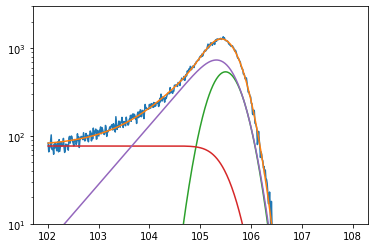

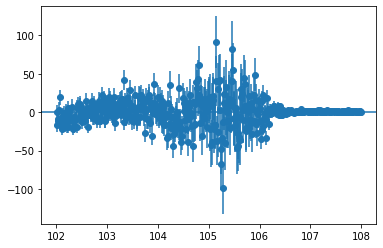

1.0916509842041016
0.9210161182056851


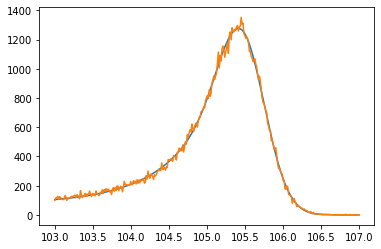

In [98]:
upper=9000
lower=8500

line_init = models.Gaussian1D(amplitude=1500, mean=105, stddev=0.2) + ConstShelf(norm=10, mean=105, stddev=0.4) + \
    ExpTail(norm=100, mean=105, stddev=0.4, slope=.1)# + models.Const1D(amplitude=20)

line_init.amplitude_0.min = 0
line_init.stddev_1.tied=tie_stddevs
line_init.mean_1.tied = tie_means
line_init.norm_1.min = 0
line_init.norm_1.max = None
line_init.stddev_2.tied=tie_stddevs
line_init.mean_2.tied = tie_means
line_init.norm_2.min = 0
line_init.norm_2.max = None

fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))

plt.plot(clean_grade0_spectrum[1][lower:upper], line[0](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[1](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[2](clean_grade0_spectrum[1][lower:upper]))
#plt.plot(clean_grade0_spectrum[1][lower:upper], line[3](clean_grade0_spectrum[1][lower:upper]))
plt.semilogy()
plt.ylim(10,3000)
plt.show()

plt.errorbar(clean_grade0_spectrum[1][lower:upper],
             clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper]),
             yerr=np.sqrt(clean_grade0_spectrum[0][lower:upper]),
             fmt='o'
            )
plt.axhline(0)
plt.show()

screened_cts = np.maximum(clean_grade0_spectrum[0][lower:upper], 1)

chisq_red = np.sum(((clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper])) ** 2)/\
                   screened_cts)/len(clean_grade0_spectrum[0][lower:upper] - 6)
print(chisq_red)

xs = np.linspace(103, 107, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(clean_grade0_spectrum[1][np.abs(clean_grade0_spectrum[1] - 105) < 2],
         clean_grade0_spectrum[0][np.abs(clean_grade0_spectrum[1] - 105) < 2])
del xs, spline
print(roots[1] - roots[0])
fwhm_105 = roots[1] - roots[0]
line_105 = line

In [26]:
from matplotlib.colors import LogNorm

In [33]:
clean_grade0_spectrum = h119_Eu155.spectrum

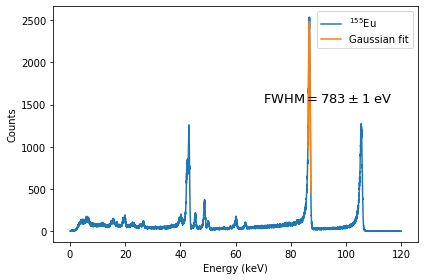

In [31]:
h119_Eu155.plot_spectrum(spectrum=clean_grade0_spectrum, fit_below=40, fit_above=50)

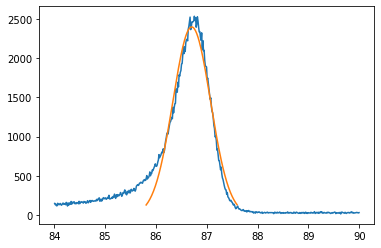

In [48]:
plt.plot(clean_grade0_spectrum[1][7000:7500], clean_grade0_spectrum[0][7000:7500])
plt.plot(clean_grade0_spectrum[1][7150:7300], line(clean_grade0_spectrum[1][7150:7300]))

In [33]:
clean_grade0_spectrum[0].argmax()

7229

In [18]:
from astropy.modeling import models, fitting

In [47]:
line_init = models.Gaussian1D(amplitude=2500, mean=87, stddev=0.8)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][7150:7300], clean_grade0_spectrum[0][7150:7300])

In [17]:
from scipy.interpolate import UnivariateSpline

In [103]:
spline = UnivariateSpline(clean_grade0_spectrum[1][4930:5000],
                          clean_grade0_spectrum[0][4930:5000] - clean_grade0_spectrum[0][4930:5000].max()/2, s=0.001)
roots = spline.roots() # find the roots

In [104]:
roots[1] - roots[0]

0.6080545679462901

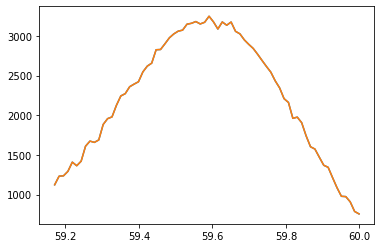

In [105]:
plt.plot(clean_grade0_spectrum[1][4930:5000], clean_grade0_spectrum[0][4930:5000])
plt.plot(clean_grade0_spectrum[1][4930:5000], spline(clean_grade0_spectrum[1][4930:5000]) + clean_grade0_spectrum[0].max()/2)

In [201]:
spline.roots()

array([59.25736209, 59.87291564, 59.99129095, 59.99687482])

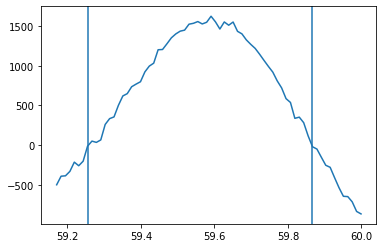

In [106]:
plt.plot(clean_grade0_spectrum[1][4930:5000], spline(clean_grade0_spectrum[1][4930:5000]))
for r in spline.roots():
    plt.axvline(r)

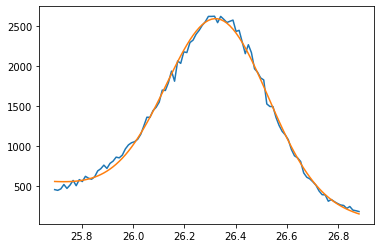

0.4677711677789126
2140


In [365]:
upper=2240
lower=2140

line_init = models.Gaussian1D(amplitude=3000, mean=26, stddev=0.8) + models.Linear1D(slope=-0.001, intercept=100)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))
plt.show()
print(line.stddev_0*2.355)

0.5157764570921799


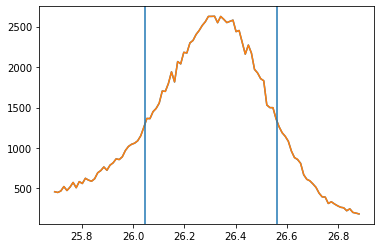

In [370]:
spline = UnivariateSpline(clean_grade0_spectrum[1][lower:upper],
                          clean_grade0_spectrum[0][lower:upper] - clean_grade0_spectrum[0][lower:upper].max()/2)
roots = spline.roots() # find the roots
print(roots[1] - roots[0])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], spline(clean_grade0_spectrum[1][lower:upper]) + clean_grade0_spectrum[0][lower:upper].max()/2)
plt.axvline(roots[0])
plt.axvline(roots[1])

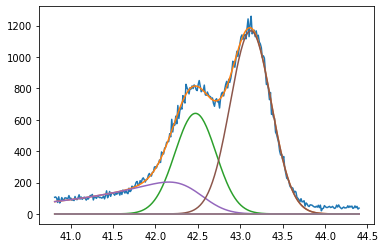

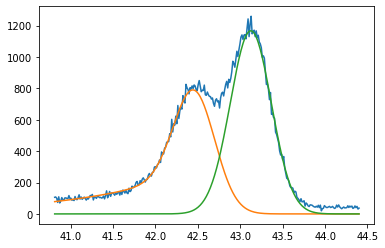

0.6421441841836284
0.5695445157707013


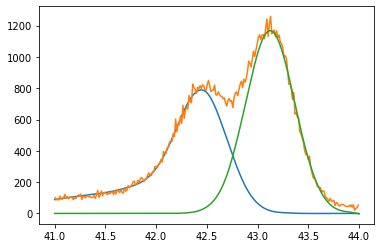

In [218]:
upper=3700
lower=3400

def tie_stddevs(model):
    return model.stddev_0

def tie_stddevs3(model):
    return model.stddev_3

def tie_means(model):
    return model.mean_0

def tie_means3(model):
    return model.mean_3

def exp_tail(x, norm=1, mean=0, stddev=1, slope=1):
    return norm*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev))

def exp_tail_deriv(x, norm=1, mean=0, stddev=1, slope=1):
    return [
        np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*np.exp(slope*(x-mean) - (x - mean)**2 / stddev**2 * 0.5)/(stddev*np.sqrt(2*np.pi)) -\
            norm*slope*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*(x-mean)*np.exp(slope*(x-mean) - (x - mean)**2 / stddev**2 * 0.5)/(stddev*stddev*np.sqrt(2*np.pi)),
        norm*(x-mean)*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev))
    ]

ExpTail = models.custom_model(exp_tail, fit_deriv=exp_tail_deriv)

def const_shelf(x, norm=1, mean=0, stddev=1):
    return norm*(1-scipy.stats.norm.cdf(x, mean, stddev))

def const_shelf_deriv(x, norm=1, mean=0, stddev=1):
    return [
        (1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*np.exp(-0.5*(x-mean)**2 / stddev**2) / (np.sqrt(2*np.pi) * stddev),
        norm*(x-mean)*np.exp(-0.5*(x-mean)**2 / stddev**2) / (np.sqrt(2*np.pi) * stddev**2)
    ]

ConstShelf = models.custom_model(const_shelf, fit_deriv=const_shelf_deriv)

line_init = models.Gaussian1D(amplitude=1000, mean=42.4, stddev=0.4) + models.Linear1D(slope=-0.001, intercept=100) + \
    models.Gaussian1D(amplitude=1500, mean=43.2, stddev=0.4)

line_init = models.Gaussian1D(amplitude=1000, mean=42.4, stddev=0.4) + ConstShelf(norm=10, mean=42.4, stddev=0.4) + \
    ExpTail(norm=100, mean=42.4, stddev=0.4, slope=0.1) + models.Gaussian1D(amplitude=1500, mean=43.2, stddev=0.4) + \
    ConstShelf(norm=10, mean=43.2, stddev=0.4) + ExpTail(norm=100, mean=43.2, stddev=0.4, slope=0.1)

line_init.amplitude_0.min = 0
line_init.stddev_1.tied=tie_stddevs
line_init.mean_1.tied = tie_means
line_init.norm_1.min = 0
line_init.norm_1.max = None
line_init.stddev_2.tied=tie_stddevs
line_init.mean_2.tied = tie_means
line_init.norm_2.min = 0
line_init.norm_2.max = None

line_init.stddev_3.tied = tie_stddevs

line_init.stddev_4.tied=tie_stddevs3
line_init.mean_4.tied = tie_means3
line_init.norm_4.min = 0
line_init.norm_4.max = None
line_init.stddev_5.tied=tie_stddevs3
line_init.mean_5.tied = tie_means3
line_init.norm_5.min = 0
line_init.norm_5.max = None

fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))

plt.plot(clean_grade0_spectrum[1][lower:upper], line[0](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[1](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[2](clean_grade0_spectrum[1][lower:upper]))

plt.plot(clean_grade0_spectrum[1][lower:upper], line[3](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[4](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[5](clean_grade0_spectrum[1][lower:upper]))

plt.show()

plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line[:3](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[3:](clean_grade0_spectrum[1][lower:upper]))
plt.show()

xs = np.linspace(41, 44, int(1e6))
spline = UnivariateSpline(xs,
                          line[:3](xs) - line[:3](xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line[:3](xs).max()/2)
plt.plot(clean_grade0_spectrum[1][np.abs(clean_grade0_spectrum[1] - 42.5) < 1.5],
         clean_grade0_spectrum[0][np.abs(clean_grade0_spectrum[1] - 42.5) < 1.5])
del xs, spline
print(roots[1] - roots[0])

xs = np.linspace(41, 44, int(1e6))
spline = UnivariateSpline(xs,
                          line[3:](xs) - line[3:](xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line[3:](xs).max()/2)
del xs, spline
print(roots[1] - roots[0])

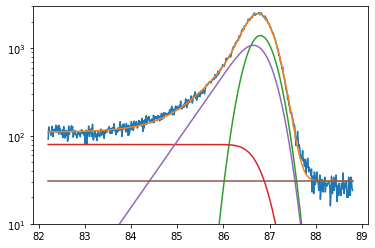

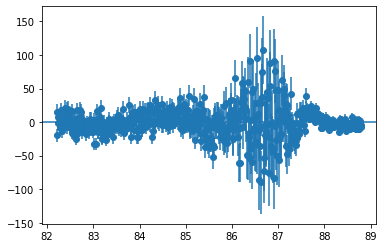

1.357284507047197
0.8049242221879922


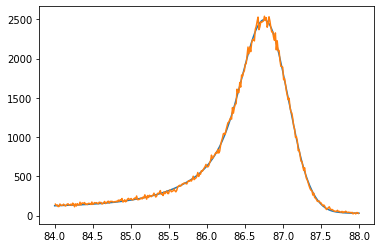

In [283]:
upper=7400
lower=6850

line_init = models.Gaussian1D(amplitude=1000, mean=86.8, stddev=0.4) + ConstShelf(norm=60, mean=86.8, stddev=0.4) + \
    ExpTail(norm=1600, mean=86.8, stddev=0.4, slope=1.5) + models.Const1D(amplitude=20)

line_init.amplitude_0.min = 0
line_init.stddev_1.tied=tie_stddevs
line_init.mean_1.tied = tie_means
line_init.norm_1.min = 0
line_init.norm_1.max = None
line_init.stddev_2.tied=tie_stddevs
line_init.mean_2.tied = tie_means
line_init.norm_2.min = 0
line_init.norm_2.max = None

fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))

plt.plot(clean_grade0_spectrum[1][lower:upper], line[0](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[1](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[2](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[3](clean_grade0_spectrum[1][lower:upper]))
plt.semilogy()
plt.ylim(10,3000)
plt.show()

plt.errorbar(clean_grade0_spectrum[1][lower:upper],
             clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper]),
             yerr=np.sqrt(clean_grade0_spectrum[0][lower:upper]),
             fmt='o'
            )
plt.axhline(0)
plt.show()
chisq_red = np.sum(((clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper])) ** 2)/\
                   clean_grade0_spectrum[0][lower:upper])/len(clean_grade0_spectrum[0][lower:upper] - 7)
print(chisq_red)

xs = np.linspace(84, 88, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(clean_grade0_spectrum[1][np.abs(clean_grade0_spectrum[1] - 86) < 2],
         clean_grade0_spectrum[0][np.abs(clean_grade0_spectrum[1] - 86) < 2])
del xs, spline
print(roots[1] - roots[0])


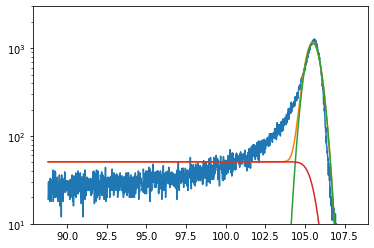

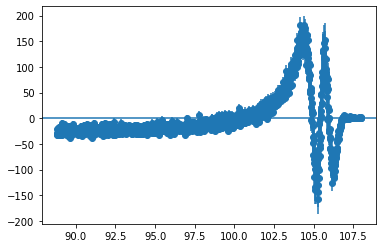

18.42750154877182
1.0614980681296515


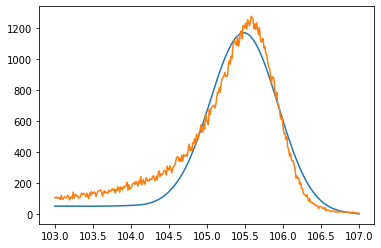

In [305]:
upper=9000
lower=7400

line_init = models.Gaussian1D(amplitude=1500, mean=105, stddev=0.4) + ConstShelf(norm=60, mean=105, stddev=0.4) + \
    ExpTail(norm=100, mean=105, stddev=0.8, slope=1)# + models.Const1D(amplitude=20)

line_init.amplitude_0.min = 0
line_init.stddev_1.tied=tie_stddevs
line_init.mean_1.tied = tie_means
line_init.norm_1.min = 0
line_init.norm_1.max = None
line_init.stddev_2.tied=tie_stddevs
line_init.mean_2.tied = tie_means
line_init.norm_2.min = 0
line_init.norm_2.max = None

fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))

plt.plot(clean_grade0_spectrum[1][lower:upper], line[0](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[1](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[2](clean_grade0_spectrum[1][lower:upper]))
#plt.plot(clean_grade0_spectrum[1][lower:upper], line[3](clean_grade0_spectrum[1][lower:upper]))
plt.semilogy()
plt.ylim(10,3000)
plt.show()

plt.errorbar(clean_grade0_spectrum[1][lower:upper],
             clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper]),
             yerr=np.sqrt(clean_grade0_spectrum[0][lower:upper]),
             fmt='o'
            )
plt.axhline(0)
plt.show()

screened_cts = np.maximum(clean_grade0_spectrum[0][lower:upper], 1)

chisq_red = np.sum(((clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper])) ** 2)/\
                   screened_cts)/len(clean_grade0_spectrum[0][lower:upper] - 6)
print(chisq_red)

xs = np.linspace(103, 107, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(clean_grade0_spectrum[1][np.abs(clean_grade0_spectrum[1] - 105) < 2],
         clean_grade0_spectrum[0][np.abs(clean_grade0_spectrum[1] - 105) < 2])
del xs, spline
print(roots[1] - roots[0])


In [301]:
line.slope_2

Parameter('slope_2', value=0.9378988678451035)

In [132]:
clean_grade0_spectrum[1][5000]

60.0109995

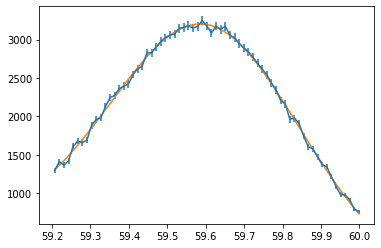

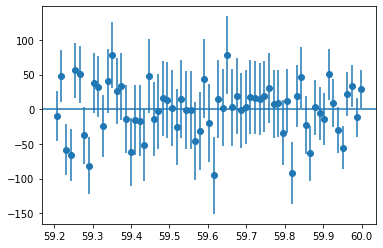

0.7678218175274625
0.6117582082842645
Model: CompoundModel41
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=3000., mean=59.6, stddev=0.3)>

    [1]: <Linear1D(slope=-1., intercept=10.)>
Parameters:
       amplitude_0           mean_0      ...      slope_1          intercept_1   
    ------------------ ----------------- ... ------------------ -----------------
    2975.1035990868104 59.59866183709552 ... -667.7715603865305 40022.22332311859


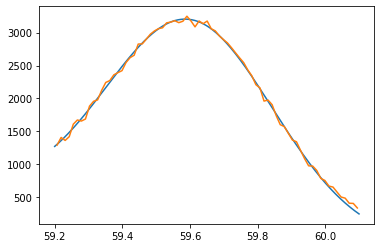

In [133]:
upper=4995
lower=4930
lower=4933
upper=5000

line_init = models.Gaussian1D(amplitude=3000, mean=59.6, stddev=0.3) + models.Linear1D(slope=-1, intercept=10-0)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.errorbar(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper],
             yerr=np.sqrt(clean_grade0_spectrum[0][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))
plt.show()

plt.errorbar(clean_grade0_spectrum[1][lower:upper],
             clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper]),
             yerr=np.sqrt(clean_grade0_spectrum[0][lower:upper]),
             fmt='o'
            )
plt.axhline(0)
plt.show()

chisq_red = np.sum(((clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper])) ** 2)/\
                   clean_grade0_spectrum[0][lower:upper])/len(clean_grade0_spectrum[0][lower:upper] - 5)

print(chisq_red)
xs = np.linspace(59.2, 60.1, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(clean_grade0_spectrum[1][np.abs(clean_grade0_spectrum[1] - 59.65) < 0.45],
         clean_grade0_spectrum[0][np.abs(clean_grade0_spectrum[1] - 59.65) < 0.45])
del xs, spline
print(roots[1] - roots[0])
print(line)

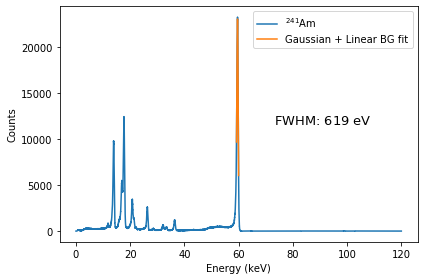

In [565]:
plt.plot(clean_grade0_spectrum[1], clean_grade0_spectrum[0], label='${}^{155}$Eu')
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]), label='Gaussian + Linear BG fit')
plt.text(0.6, 0.5, f'FWHM: ${619:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)
plt.legend()
#plt.title('Full Frame Spectrum, Single Pixel Events Only')
plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.tight_layout()
plt.savefig('energy_spectrum_floodAm241_5C_-500V_20190725_gain_grade0_GaussLinBG.pdf')

In [487]:
line

<CompoundModel115(amplitude_0=21115.3998748, mean_0=59.60044444, stddev_0=0.24368647, slope_1=-5104.3561973, intercept_1=306063.72795554)>

In [447]:
np.sqrt(fit_line.fit_info['cov_x'][2,2])*2.355*1000

0.05092735941567342

In [457]:
2.355*1000*np.sqrt(fit_line.fit_info['cov_x'][2,2]*((clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper])) ** 2).sum()/(len(line(clean_grade0_spectrum[1][lower:upper])) - 5))

6.64907217768257

In [469]:
np.sqrt(fit_line.fit_info['param_cov'][2,2])*2.355*1000

6.64907217768257

In [483]:
def pixel_mask(x, y):
    return (h119_Am241.raw_data_1d['RAWX'] == x) & (h119_Am241.raw_data_1d['RAWY'] == y)

0.6101102477852365


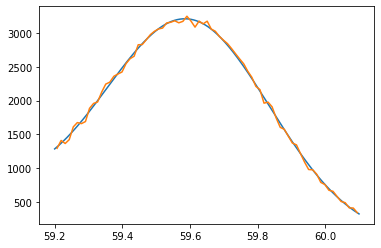

In [108]:
xs = np.linspace(59.2, 60.1, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(clean_grade0_spectrum[1][np.abs(clean_grade0_spectrum[1] - 59.65) < 0.45],
         clean_grade0_spectrum[0][np.abs(clean_grade0_spectrum[1] - 59.65) < 0.45])
del xs, spline
print(roots[1] - roots[0])

In [541]:
clean_grade0_spectrum[1][4999]

59.999000499999994

In [ ]:
fit_line(clean_grade0_spectrum, lower=7183, upper=7270, energy=86.8)

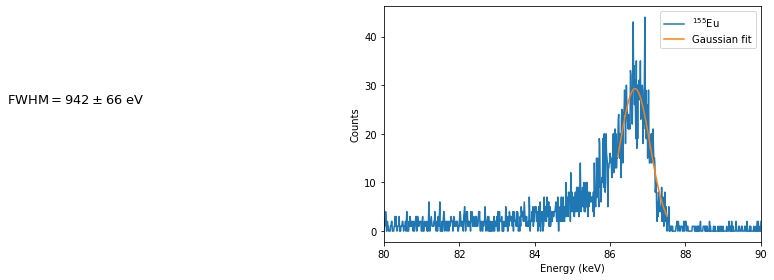

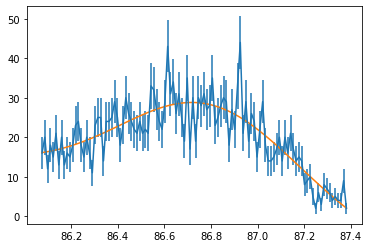

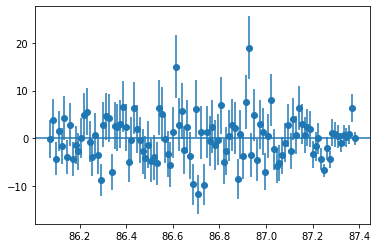

1.2956264484653262


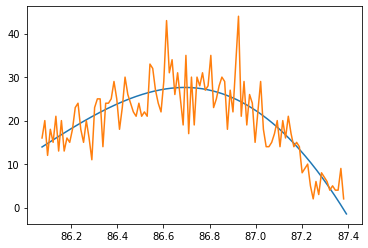

1.0842872522970168


In [28]:
i, j = 16, 14
cts, edges = np.histogram(h119_Eu155._energy_map[j][i], bins=10000, range=(0.1, 120))
h119_Eu155.plot_spectrum(spectrum=np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), save_plot=False,
                         fit_below=60, fit_above=50)
plt.xlim(80,90)
plt.show()
#print(i,j)
fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=7170, upper=7280, energy=86.8,
                                  plot=True)
            #fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=7170, upper=7270, energy=86.8, plot=False)
            #fwhm_map[i][j] = fwhm*1000
#            fwhm_map_low[i][j] = fwhm*1000
        
#fwhm_map = np.ma.masked_equal(fwhm_map, 1)
#fwhm_map_low = np.ma.masked_equal(fwhm_map_low, 1)

In [133]:
channel = h119_Eu155.raw_data_1d.loc[pixel_mask(16,14) & grade_mask, 'PH'].values
chan_low, chan_high = h119_Eu155.source.chan_range(None, 0.013,
            width=1000)
spectrum, edges = np.histogram(channel, bins=np.arange(1,10000), 
                        range=(0, 10000))
                    # 'centroid' is the channel with the most counts in the 
                    # interval between 'chan_low' and 'chan_high'.
centroid = np.argmax(spectrum[chan_low:chan_high]
                       ) + chan_low
fit_below=70
fit_above=50
fit_channels = np.arange(
                        centroid - fit_below, centroid + fit_above)
g_init = models.Gaussian1D(amplitude=spectrum[centroid], 
                        mean=centroid, stddev=75)# + models.Linear1D(slope=.001, intercept=-50)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, fit_channels, spectrum[fit_channels])
print(g.mean)

Parameter('mean', value=6942.984309202195)


6952.640738661447

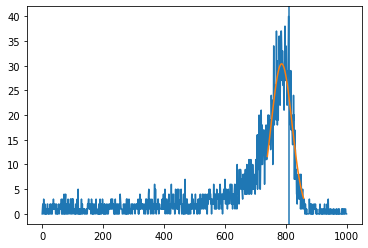

In [134]:
plt.plot(spectrum[chan_low:chan_high])
plt.axvline(np.argmax(spectrum[chan_low:chan_high]
                       ))
plt.plot(fit_channels - chan_low, g(fit_channels))
6952.640738661447

In [29]:
i, j = 17, 12
fwhm_map = np.ones((32,32))
#fwhm_map_low = np.ones((32,32))
for i in range(14,19):
    for j in range(12,17):
        if len(h119_Eu155._energy_map[j][i]) and not (i==16 and j==14):
            cts, edges = np.histogram(h119_Eu155._energy_map[j][i], bins=10000, range=(0.1, 120))
#h119_Am241.plot_spectrum(spectrum=np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), save_plot=False,
#                         fit_below=30, fit_above=40)
#plt.show()
            print(i,j)
            fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=7170, upper=7275, energy=86.8,
                                  plot=False)
            #fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=4930, upper=5000, plot=False)
            fwhm_map[i][j] = fwhm*1000
            #fwhm_map_low[i][j] = fwhm*1000
        
fwhm_map = np.ma.masked_equal(fwhm_map, 1)
#fwhm_map_low = np.ma.masked_equal(fwhm_map_low, 1)

14 12
1.192000128571755
0.8119368465553833
14 13
1.0493962452683387
0.7971479356798596
14 14
0.9699654719454697
0.7958952095000456
14 15
1.1495222901163586
0.7235160521288009
14 16
1.138708492992559
0.8845986008745541
15 12
1.2850389396926754
0.7413048198180547
15 13
1.2575418164141408
0.7905759293026904
15 14
1.2482275845593984
0.7380066366015114
15 15
1.1311473997352754
0.7496690687546703
15 16
1.005169845150927
0.6964540670692543
16 12
0.8428165528150275
0.8226132149271734
16 13
1.1077211487055565
0.6981459456922181
16 15
1.1577397037694173
0.7150833207075777
16 16
0.7978999349475588
0.9727516468220188
17 12
0.9650009448307325
0.7027763347082754
17 13
1.1048922610925316
0.8664860074683105
17 15
1.3838917436182547
0.6900236949637559
17 16
0.8864587961667412
0.7859801006922567
18 12
1.279154271448466
0.794663413027962
18 13
1.2560722369509343
0.9058848391055534
18 14
0.9317855837883585
0.9341578112911577
18 15
0.8057470591216565
0.8438527245157985
18 16
1.0632817885745343
1.0657449002

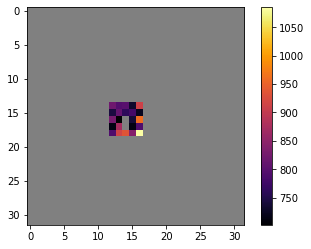

NameError: name 'fwhm_map_low' is not defined

In [148]:
cmap = matplotlib.cm.get_cmap('inferno')
cmap.set_bad(color='gray')
plt.imshow(fwhm_map, cmap = cmap)
plt.colorbar()
plt.show()

cmap = matplotlib.cm.get_cmap('inferno')
cmap.set_bad(color='gray')
plt.imshow(fwhm_map_low, cmap = cmap)
plt.colorbar()
plt.show()

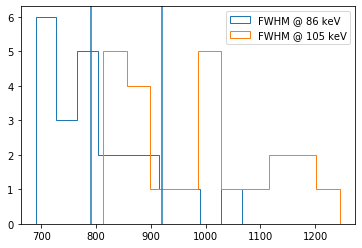

In [108]:
plt.hist(fwhm_map.data.flatten()[fwhm_map.data.flatten() > 1], histtype='step', label='FWHM @ 86 keV')
plt.axvline(fwhm_86*1000)
plt.hist(fwhm_map_hi.flatten()[fwhm_map_hi.flatten() > 1], histtype='step', label='FWHM @ 105 keV')
plt.axvline(fwhm_105*1000)
plt.legend()
plt.show()

In [15]:
import matplotlib

In [38]:
def fit_line(spec, lower=7150, upper=7300, energy=86.6, plot=True, intercept=1000, slope=-20):
    #upper=4995
    #lower=4930
    #lower=4920
    #upper=5010

    line_init = models.Gaussian1D(amplitude=np.max(spec[0]), mean=energy, stddev=0.3) + \
        models.Linear1D(slope=slope, intercept=intercept)
    fit_l = fitting.LevMarLSQFitter()
    line = fit_l(line_init, spec[1][lower:upper], spec[0][lower:upper])
    if plot:
        plt.errorbar(spec[1][lower:upper], spec[0][lower:upper],
             yerr=np.sqrt(spec[0][lower:upper]))
        plt.plot(spec[1][lower:upper], line(spec[1][lower:upper]))
        plt.show()

        plt.errorbar(spec[1][lower:upper],
             spec[0][lower:upper] - line(spec[1][lower:upper]),
             yerr=np.sqrt(spec[0][lower:upper]),
             fmt='o'
            )
        plt.axhline(0)
        plt.show()
    
    screened_cts = np.maximum(spec[0][lower:upper], 1)

    chisq_red = np.sum(((spec[0][lower:upper] - line(spec[1][lower:upper])) ** 2)/
                   screened_cts)/len(spec[0][lower:upper] - 5)

    print(chisq_red)
    xs = np.linspace(spec[1][lower], spec[1][upper], int(1e6))
    spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
    roots = spline.roots() # find the roots
    if plot:
        plt.plot(xs, spline(xs)+line(xs).max()/2)
        plt.plot(spec[1][lower:upper],
         spec[0][lower:upper])
        plt.show()
    del xs, spline
    print(roots[1] - roots[0])
    return roots[1] - roots[0], line
    #print(line)

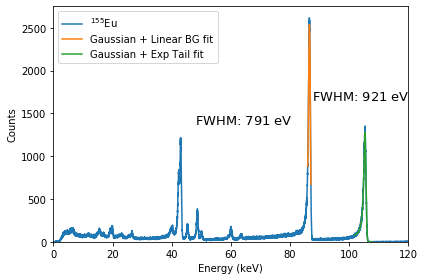

In [121]:
plt.plot(clean_grade0_spectrum[1], clean_grade0_spectrum[0], label='${}^{155}$Eu')
plt.plot(clean_grade0_spectrum[1][7167:7259], line_86(clean_grade0_spectrum[1][7167:7259]), label='Gaussian + Linear BG fit')
plt.plot(clean_grade0_spectrum[1][8500:9000], line_105(clean_grade0_spectrum[1][8500:9000]), label='Gaussian + Exp Tail fit')
plt.text(0.4, 0.5, f'FWHM: ${fwhm_86*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)
plt.text(0.73, 0.6, f'FWHM: ${fwhm_105*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)
plt.xlim(0,120)
plt.ylim(0,2750)
plt.legend()
#plt.title('Full Frame Spectrum, Single Pixel Events Only')
plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.tight_layout()
plt.savefig('energy_spectrum_floodEu155_5C_-500V_20190816_small_region_capoffset.pdf')

In [113]:
best_pixels = [(14, 12), (14, 14), (14, 15),
              (15, 16),
              (16, 13), (16, 15),
              (17, 12), (17, 15), (17, 16),
              (18, 12)]
#best_pixels = [(17, 12), (18, 12), (17, 15)]
best_energy_map = []
#for i, j in best_pixels:
for i in range(14,19):
    for j in range(12,17):
        best_energy_map += h119_Am241._energy_map[j][i]

cts, edges = np.histogram(best_energy_map, bins=10000, range=(0.1, 120))
spec = np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5])


lower=4933
upper=5000
fwhm, line = fit_line(spec, lower=lower, upper=upper, plot=False)

plt.plot(spec[1][(spec[1] < 62) & (spec[1] > 0)], spec[0][(spec[1] < 62) & (spec[1] > 0)], label='${}^{241}$Am')
plt.plot(spec[1][lower:upper], line(spec[1][lower:upper]), label='Gaussian + Linear BG fit')
plt.text(0.6, 0.5, f'FWHM: ${fwhm*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)

lower=1120
upper=1190
fwhm, line = fit_line(spec, lower=lower, upper=upper, energy=14, plot=False)
plt.plot(spec[1][lower:upper],
         line(spec[1][lower:upper]),
         label='Gaussian + Linear BG fit')
plt.text(0.1, 0.55, f'FWHM: ${fwhm*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)


plt.legend()
#plt.title('10 Best Pixels Between (14, 12) and (18, 16), Single Pixel Events Only')
plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.tight_layout()
plt.show()


NameError: name 'h119_Am241' is not defined

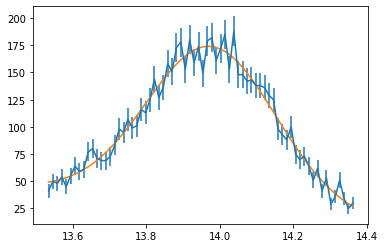

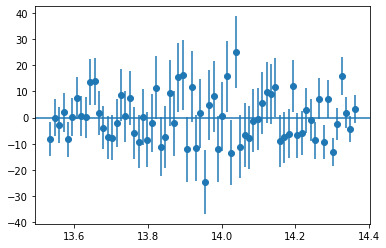

0.8574638100076426


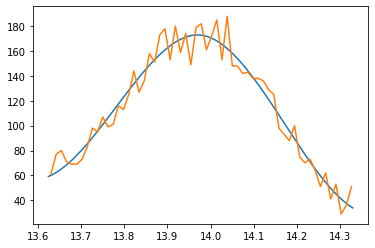

0.47988043276486536


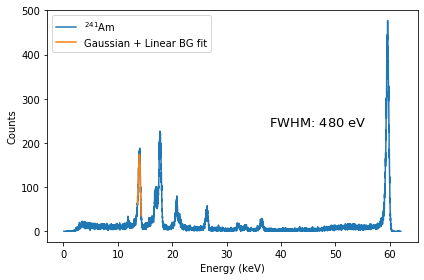

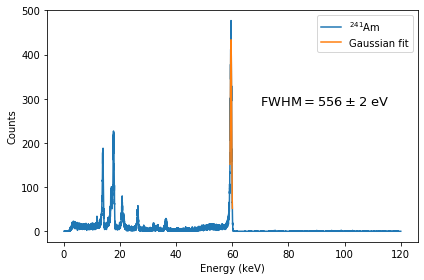

In [263]:
best_pixels = [(14, 12), (14, 14), (14, 15),
              (15, 16),
              (16, 13), (16, 15),
              (17, 12), (17, 15), (17, 16),
              (18, 12)]
best_pixels = [(17, 12), (18, 12), (17, 15)]
best_energy_map = []
for i, j in best_pixels:
    best_energy_map += h119_Am241._energy_map[j][i]

cts, edges = np.histogram(best_energy_map, bins=10000, range=(0.1, 120))
spec = np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5])

fwhm, line = fit_line(spec, lower=1120, upper=1190, energy=14)


plt.plot(spec[1][(spec[1] < 62) & (spec[1] > 0)], spec[0][(spec[1] < 62) & (spec[1] > 0)], label='${}^{241}$Am')
plt.plot(spec[1][(spec[1] < line.mean_0+line.stddev_0*2) & (spec[1] > line.mean_0-line.stddev_0*2)],
         line(spec[1][(spec[1] < line.mean_0+line.stddev_0*2) & (spec[1] > line.mean_0-line.stddev_0*2)]),
         label='Gaussian + Linear BG fit')
plt.text(0.6, 0.5, f'FWHM: ${fwhm*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)
plt.legend()
#plt.title('10 Best Pixels Between (14, 12) and (18, 16), Single Pixel Events Only')
plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.tight_layout()
plt.show()
h119_Am241.plot_spectrum(spectrum=np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), save_plot=False,
                         fit_below=30, fit_above=40)
plt.show()


In [ ]:
plt.hist([h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 0)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 1)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 2)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 3)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 4)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 4)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 4)]['PH']],
         np.arange(1, 6000), histtype='barstacked')
plt.savefig('energy_spectrum_Am241_17_14_by_grade.pdf')
plt.show()

plt.hist(other_data[pixel_mask(17, 14)]['GRADE'], bins=np.arange(14))
plt.show()

In [94]:
def pixel_mask(x, y):
    return (h119_Eu155.raw_data_1d['RAWX'] == x) & (h119_Eu155.raw_data_1d['RAWY'] == y)

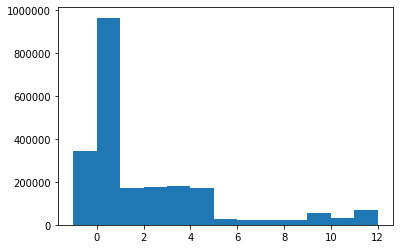

(array([1.17206e+05, 3.74200e+03, 2.07300e+03, 4.49500e+03, 5.13800e+03,
        2.78700e+03, 7.21000e+02, 4.84000e+02, 1.28200e+03, 3.27600e+03,
        1.86700e+03, 1.48000e+03, 2.63300e+03, 1.87100e+03, 3.24000e+02,
        2.00000e+02, 2.47000e+02, 1.09000e+02, 5.06000e+02, 1.98000e+02,
        6.18000e+02, 0.00000e+00, 8.90000e+01, 6.90000e+01, 0.00000e+00,
        2.80000e+01, 3.16000e+02, 5.97000e+02, 3.98700e+03, 1.15500e+03,
        8.70000e+01, 2.96500e+03]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
        25., 26., 27., 28., 29., 30., 31.]),
 <a list of 32 Patch objects>)

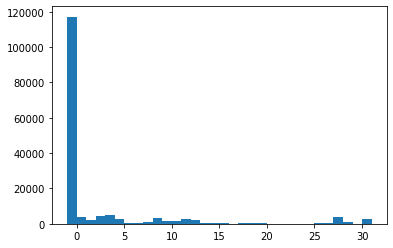

In [373]:
plt.hist(other_data['GRADE'], bins=13)
plt.show()
plt.hist(even_more_data['GRADE'].loc[pixel_mask(17, 14)], bins=32)

In [334]:
even_more_data, _ = nudetect.fits_to_df("floodEu155_5C_-500V_20190816_small_region_all_grades.fits",
                                   ["GRADE"],
                                   pos=0)

In [340]:
gradesums = np.loadtxt('log.txt')

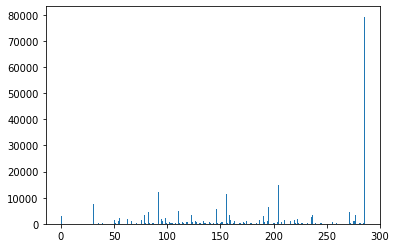

In [363]:
h= plt.hist(gradesums, bins=np.arange(287))

In [364]:
cts = h[0]

In [368]:
edges = h[1][:-1]

In [372]:
gradesums.shape

(226783,)

In [84]:
def fit_105(spec, upper=9000, lower=8500):
    line_init = models.Gaussian1D(amplitude=100, mean=105, stddev=0.2) + ConstShelf(norm=1, mean=105, stddev=0.4) + \
        ExpTail(norm=10, mean=105, stddev=0.4, slope=.1)# + models.Const1D(amplitude=20)

    line_init.amplitude_0.min = 0
    line_init.stddev_1.tied=tie_stddevs
    line_init.mean_1.tied = tie_means
    line_init.norm_1.min = 0
    line_init.norm_1.max = None
    line_init.stddev_2.tied=tie_stddevs
    line_init.mean_2.tied = tie_means
    line_init.norm_2.min = 0
    line_init.norm_2.max = None
    
    fitter = fitting.LevMarLSQFitter()
    line = fitter(line_init, spec[1][lower:upper], spec[0][lower:upper])
    plt.plot(spec[1][lower:upper], spec[0][lower:upper])
    plt.plot(spec[1][lower:upper], line(spec[1][lower:upper]))

    plt.plot(spec[1][lower:upper], line[0](spec[1][lower:upper]))
    plt.plot(spec[1][lower:upper], line[1](spec[1][lower:upper]))
    plt.plot(spec[1][lower:upper], line[2](spec[1][lower:upper]))
    #plt.plot(clean_grade0_spectrum[1][lower:upper], line[3](clean_grade0_spectrum[1][lower:upper]))
    plt.semilogy()
    plt.ylim(10,3000)
    plt.show()

    plt.errorbar(spec[1][lower:upper],
             spec[0][lower:upper] - line(spec[1][lower:upper]),
             yerr=np.sqrt(spec[0][lower:upper]),
             fmt='o'
            )
    plt.axhline(0)
    plt.show()

    screened_cts = np.maximum(spec[0][lower:upper], 1)

    chisq_red = np.sum(((spec[0][lower:upper] - line(spec[1][lower:upper])) ** 2)/\
                   screened_cts)/len(spec[0][lower:upper] - 6)
    print(chisq_red)

    xs = np.linspace(103, 107, int(1e6))
    spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
    roots = spline.roots() # find the roots
    plt.plot(xs, spline(xs)+line(xs).max()/2)
    plt.plot(spec[1][np.abs(clean_grade0_spectrum[1] - 105) < 2],
         spec[0][np.abs(clean_grade0_spectrum[1] - 105) < 2])
    plt.show()
    del xs, spline
    print(roots[1] - roots[0])
    return roots[1] - roots[0], line

14 12


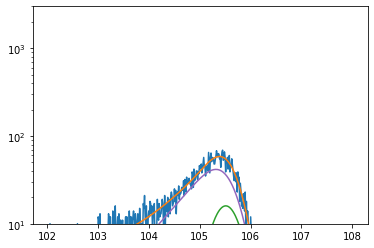

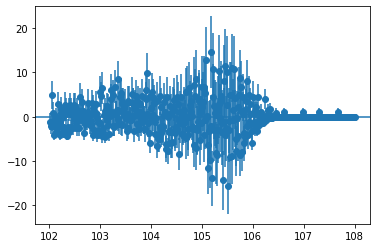

0.9717971673629986


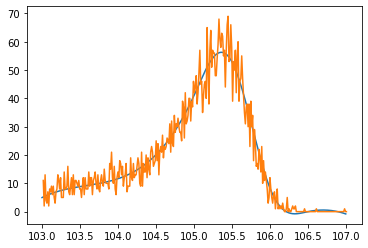

1.0074943788037558
14 13


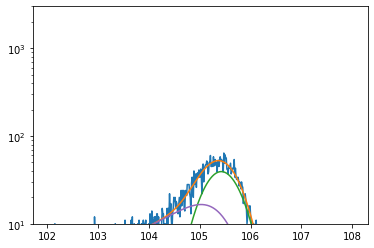

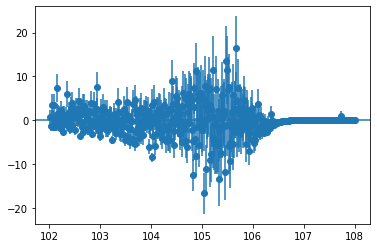

1.153040121890989


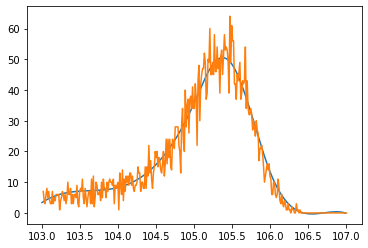

1.0202203977566882
14 14


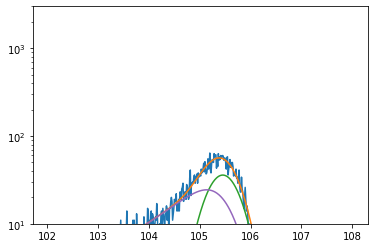

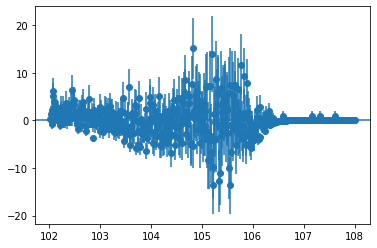

0.856598387669203


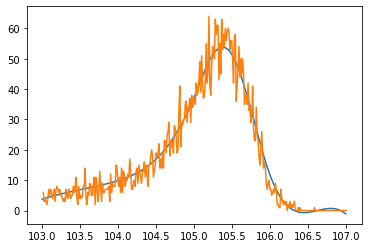

0.9759932462805097
14 15


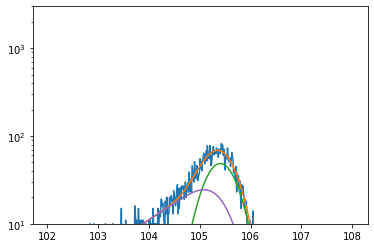

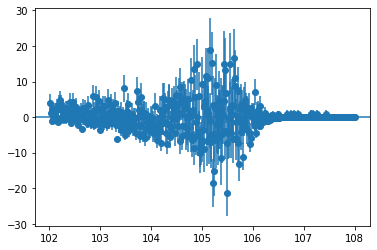

1.0078277548171035


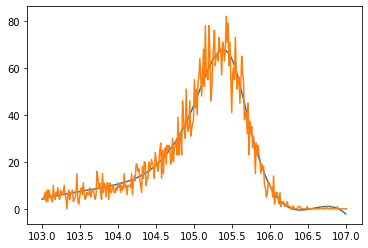

0.8852989892653795
14 16


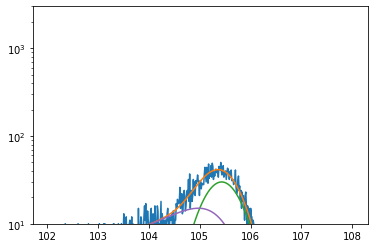

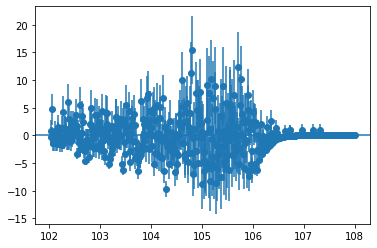

1.3104630298810587


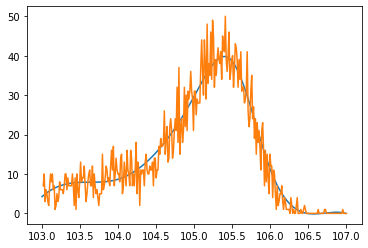

1.125084352678158
15 12


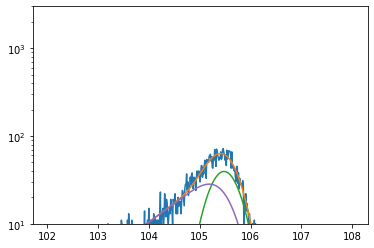

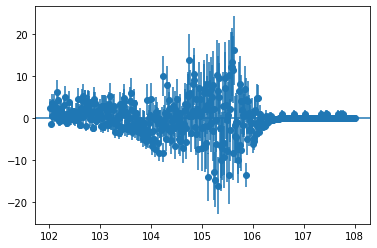

1.0427779961794497


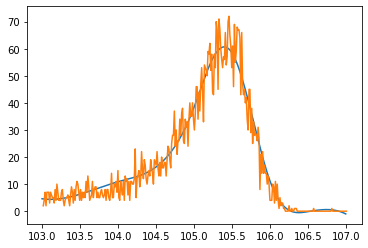

0.8978067565848988
15 13


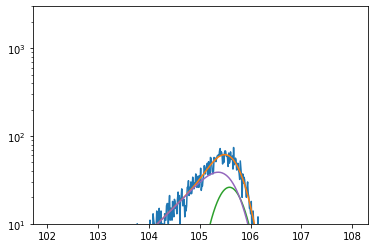

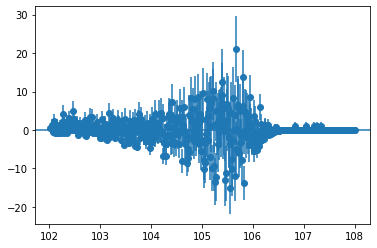

0.8985015899513055


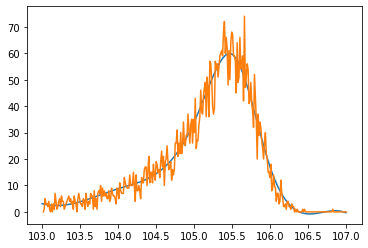

0.9149734258411542
15 14


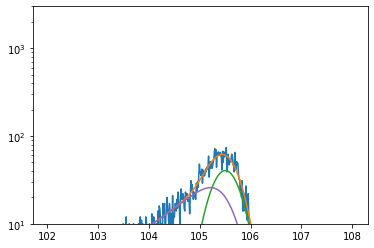

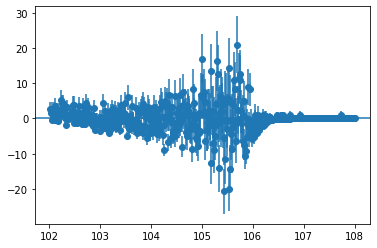

1.09803316329602


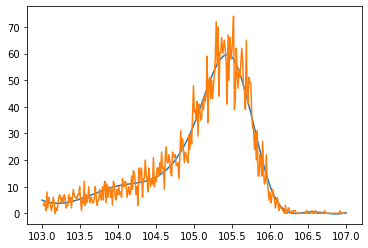

0.8429332208254579
15 15


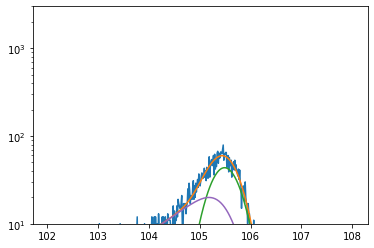

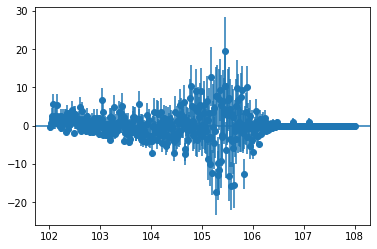

1.0231807254550576


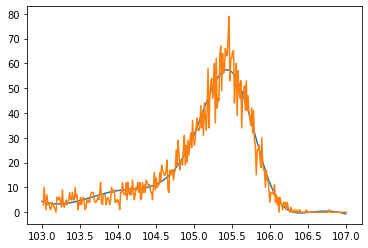

0.8343300687628101
15 16


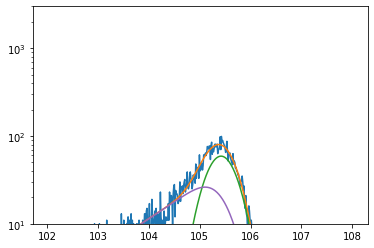

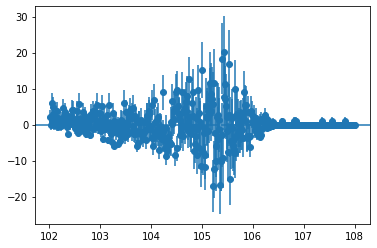

1.1226085752836705


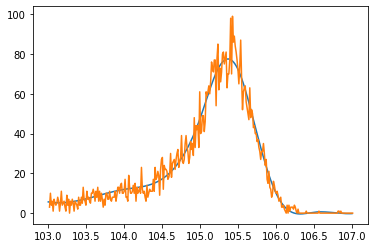

0.8266635497077743
16 12


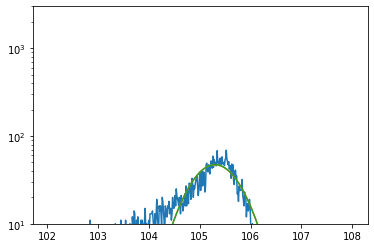

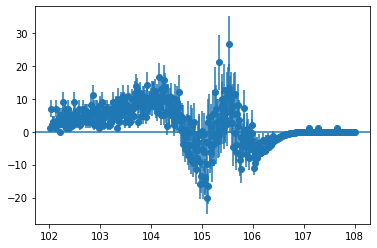

3.6864075701350174


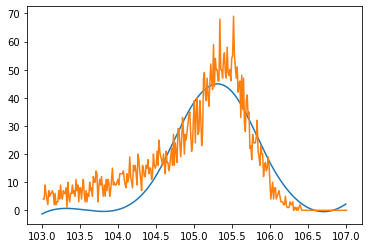

1.1645123030789506
16 13


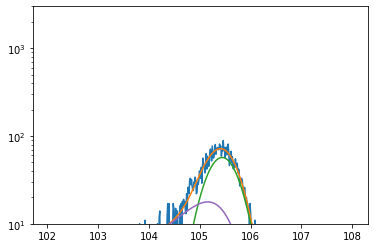

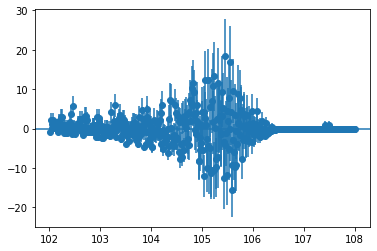

0.9440428757276964


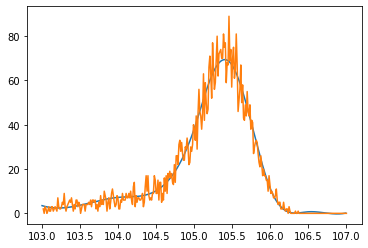

0.8124130262527274
16 15


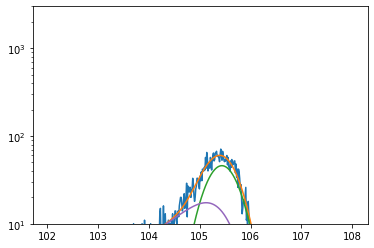

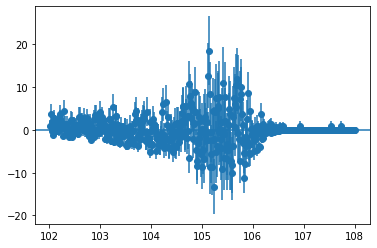

0.9546378628244295


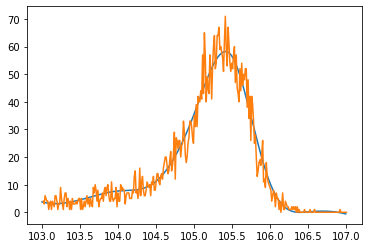

0.8703030819494444
16 16


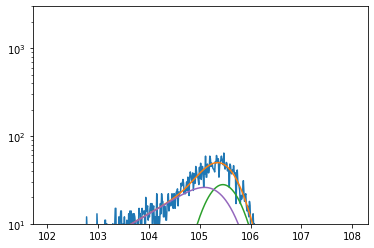

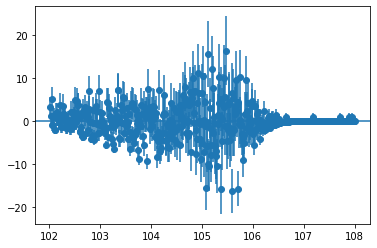

1.3052366667740203


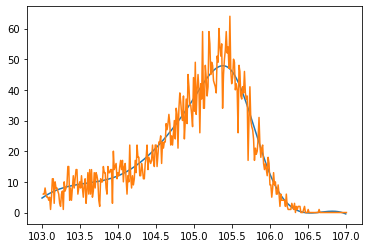

1.190522831337816
17 12


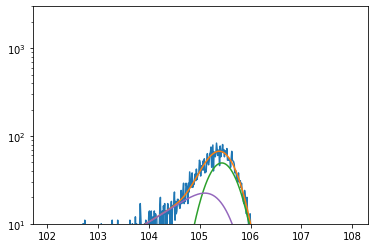

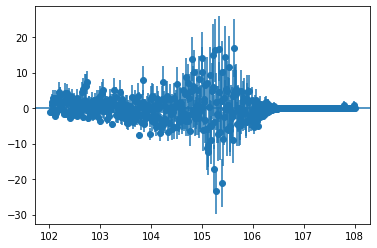

1.1437541877406456


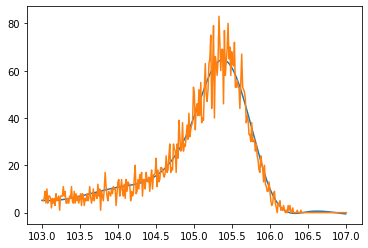

0.8669390775945089
17 13


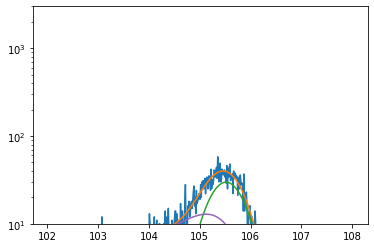

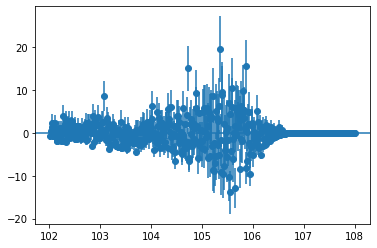

1.1071106101278012


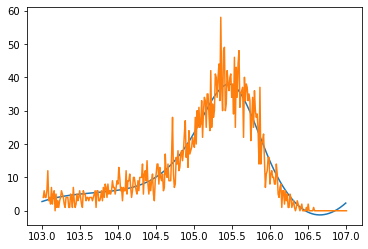

0.9967049509408525
17 15


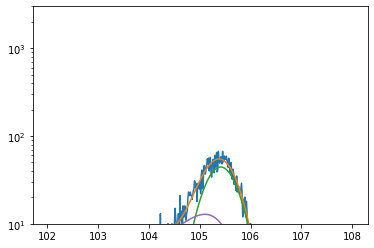

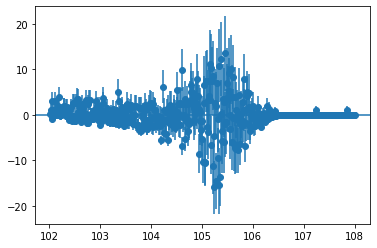

0.8925106836428842


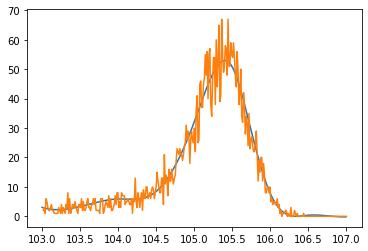

0.8365681136203449
17 16


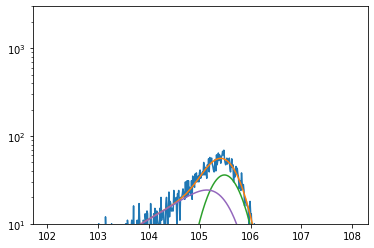

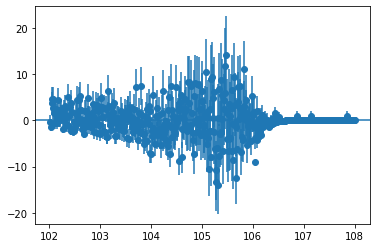

0.9892891610820335


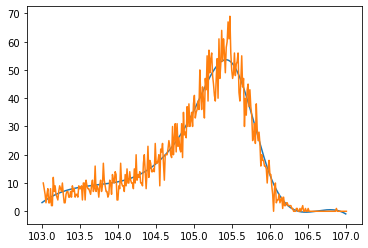

0.9873390260464134
18 12


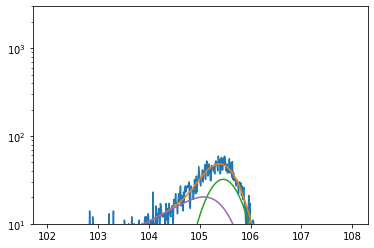

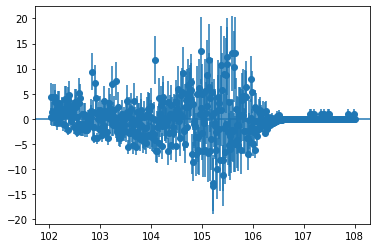

0.9746358334739428


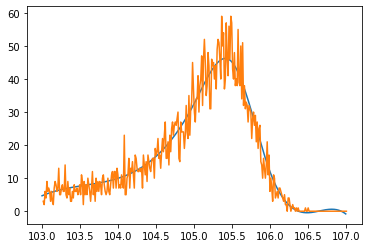

1.050692619702616
18 13


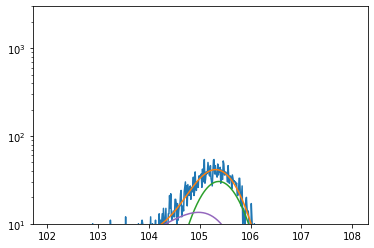

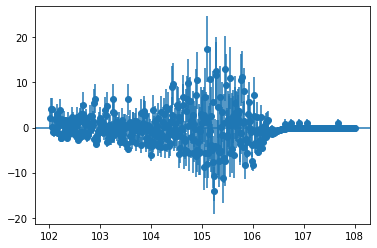

1.2113790588319693


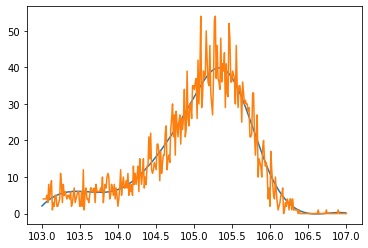

1.1441665873904014
18 14


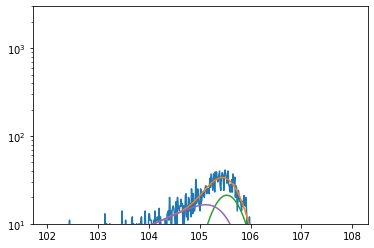

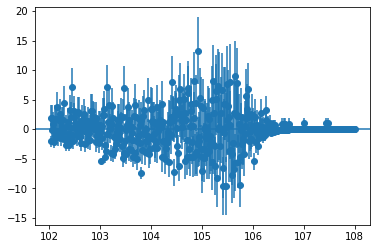

1.0068594744678068


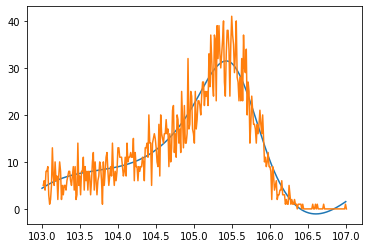

1.0910761872130479
18 15


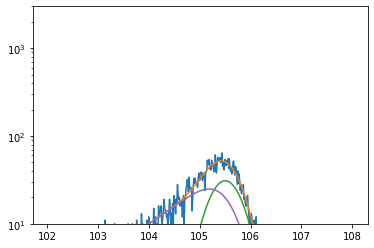

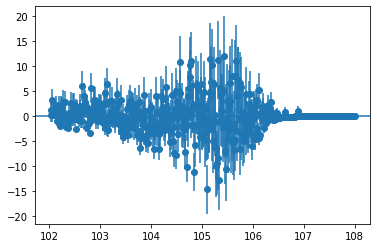

0.8574198142725408


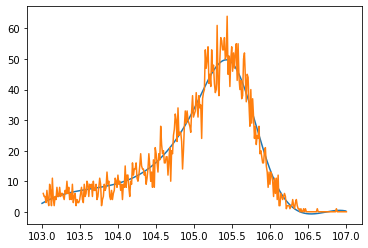

1.017406952393415
18 16


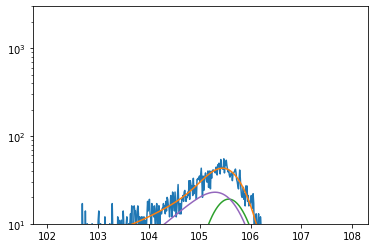

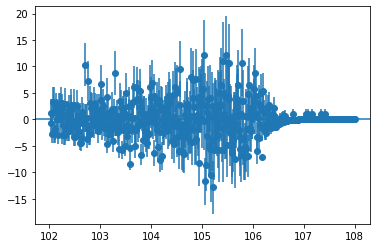

1.0720900641363653


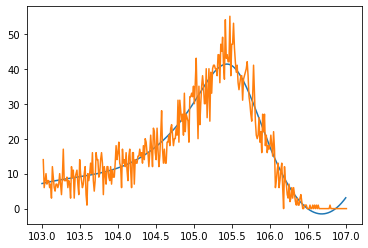

1.2459231573194671


In [86]:
i, j = 17, 12
#fwhm_map = np.ones((32,32))
fwhm_map_hi = np.ones((32,32))
for i in range(14,19):
    for j in range(12,17):
        if len(h119_Eu155._energy_map[j][i]) and not (i==16 and j==14):
            cts, edges = np.histogram(h119_Eu155._energy_map[j][i], bins=10000, range=(0.1, 120))
#h119_Am241.plot_spectrum(spectrum=np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), save_plot=False,
#                         fit_below=30, fit_above=40)
#plt.show()
            print(i,j)
            fwhm, line = fit_105(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]))
            #fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=4930, upper=5000, plot=False)
            #fwhm_map[i][j] = fwhm*1000
            fwhm_map_hi[i][j] = fwhm*1000
        
#fwhm_map = np.ma.masked_equal(fwhm_map, 1)
fwhm_map_hi = np.ma.masked_equal(fwhm_map_hi, 1)

16 12


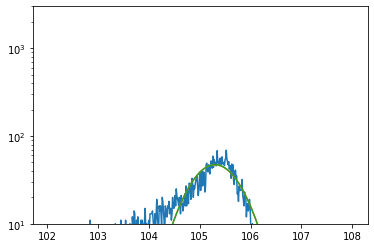

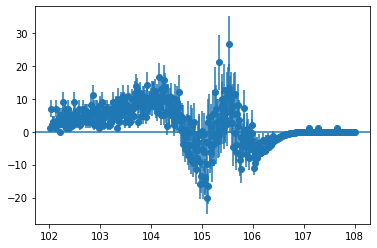

3.6864075701350174


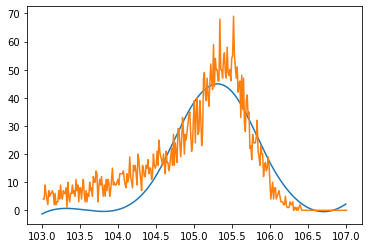

1.1645123030789506


In [87]:
i, j = 16, 12
cts, edges = np.histogram(h119_Eu155._energy_map[j][i], bins=10000, range=(0.1, 120))
#h119_Am241.plot_spectrum(spectrum=np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), save_plot=False,
#                         fit_below=30, fit_above=40)
#plt.show()
print(i,j)
fwhm, line = fit_105(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]))
#fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=4930, upper=5000, plot=False)
#fwhm_map[i][j] = fwhm*1000
fwhm_map_hi[i][j] = fwhm*1000

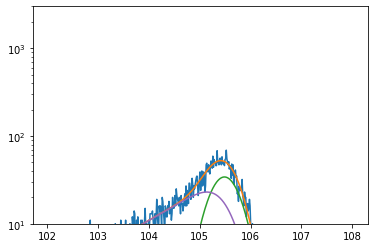

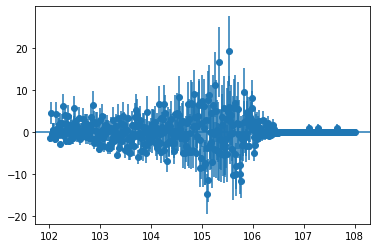

0.8375497275981982


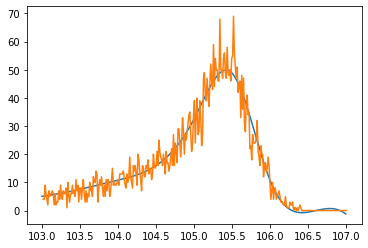

0.9523879098343997


NameError: name 'fwhm_array_hi' is not defined

In [91]:
spec = np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5])
upper=9000
lower=8500
line_init = models.Gaussian1D(amplitude=50, mean=105, stddev=0.2) + ConstShelf(norm=1, mean=105, stddev=0.4) + \
        ExpTail(norm=10, mean=105, stddev=0.4, slope=.1)# + models.Const1D(amplitude=20)

line_init.amplitude_0.min = 0
line_init.stddev_1.tied=tie_stddevs
line_init.mean_1.tied = tie_means
line_init.norm_1.min = 0
line_init.norm_1.max = None
line_init.stddev_2.tied=tie_stddevs
line_init.mean_2.tied = tie_means
line_init.norm_2.min = 0
line_init.norm_2.max = None
    
fitter = fitting.LevMarLSQFitter()
line = fitter(line_init, spec[1][lower:upper], spec[0][lower:upper])
plt.plot(spec[1][lower:upper], spec[0][lower:upper])
plt.plot(spec[1][lower:upper], line(spec[1][lower:upper]))

plt.plot(spec[1][lower:upper], line[0](spec[1][lower:upper]))
plt.plot(spec[1][lower:upper], line[1](spec[1][lower:upper]))
plt.plot(spec[1][lower:upper], line[2](spec[1][lower:upper]))
#plt.plot(clean_grade0_spectrum[1][lower:upper], line[3](clean_grade0_spectrum[1][lower:upper]))
plt.semilogy()
plt.ylim(10,3000)
plt.show()

plt.errorbar(spec[1][lower:upper],
             spec[0][lower:upper] - line(spec[1][lower:upper]),
             yerr=np.sqrt(spec[0][lower:upper]),
             fmt='o'
            )
plt.axhline(0)
plt.show()

screened_cts = np.maximum(spec[0][lower:upper], 1)

chisq_red = np.sum(((spec[0][lower:upper] - line(spec[1][lower:upper])) ** 2)/\
                   screened_cts)/len(spec[0][lower:upper] - 6)
print(chisq_red)

xs = np.linspace(103, 107, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(spec[1][np.abs(clean_grade0_spectrum[1] - 105) < 2],
         spec[0][np.abs(clean_grade0_spectrum[1] - 105) < 2])
plt.show()
del xs, spline
print(roots[1] - roots[0])
fwhm_array_hi[16][12] = 1000*(roots[1] - roots[0])

In [109]:
fwhm_map_86 = fwhm_map
fwhm_map_105 = fwhm_map_hi
np.savez('eu155_data', fwhm_map_86=fwhm_map_86, fwhm_map_105=fwhm_map_105, fwhm_86=fwhm_86, fwhm_105=fwhm_105)

In [112]:
fwhm_map_hi.max()

1245.923157319467